In [1]:
# install dependencies
%pip install pandas
%pip install numpy
%pip install scikit-learn
%pip install tldextract
%pip install matplotlib
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.



In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tldextract as tlde
import matplotlib.pyplot as plt
import re

In [3]:
#load data and check if valid
NUM_SAMPLES = 150000
df = pd.read_csv("malicious_phish.csv")
df = df.sample(n=NUM_SAMPLES, replace=False, random_state=51)
df.shape


,url,type
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign
601223,www.battle.com.wwowus.net/login/en/?3Fref=eu.b...,benign
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign
64374,kvha.org/,benign


In [4]:
df.isnull().sum()

url     0
type    0
dtype: int64

In [5]:
type_counts = df["type"].value_counts()
type_counts

type
benign        164165
defacement     37049
phishing       36239
malware        12547
Name: count, dtype: int64

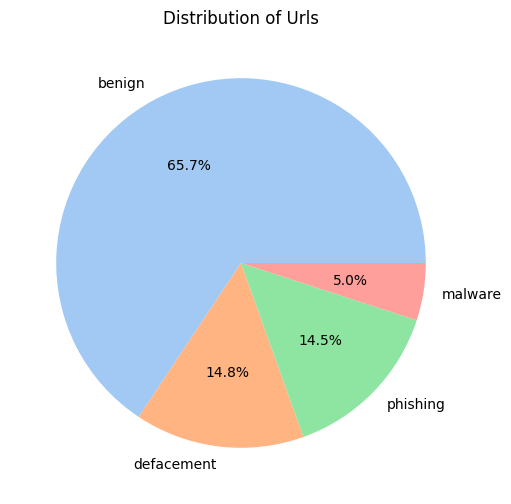

In [6]:
# display distribution
plt.figure(figsize=(6, 6))
plt.pie(
    type_counts,
    labels=type_counts.index,
    autopct="%1.1f%%", # percentage formatting
    colors=sns.color_palette("pastel"),
)
plt.title("Distribution of Urls")
plt.show()


In [7]:
# remove www. from all URLs
df["url"] = df["url"].str.replace("www", "")
df.head()


,url,type
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign
64374,kvha.org/,benign


In [8]:
# create categories and add it to the data frame
url_categories = {
    "benign": 0,
    "phishing": 1,
    "defacement": 2,
    "malware": 3
}

df["category"] = df["type"].map(url_categories)

df.head()

,url,type,category
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0
64374,kvha.org/,benign,0


In [9]:
# Analyze if there exists a relationship between URL length and being a non-benign URL
df["url_length"] = df["url"].apply(len)

df.head()

,url,type,category,url_length
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89
64374,kvha.org/,benign,0,9


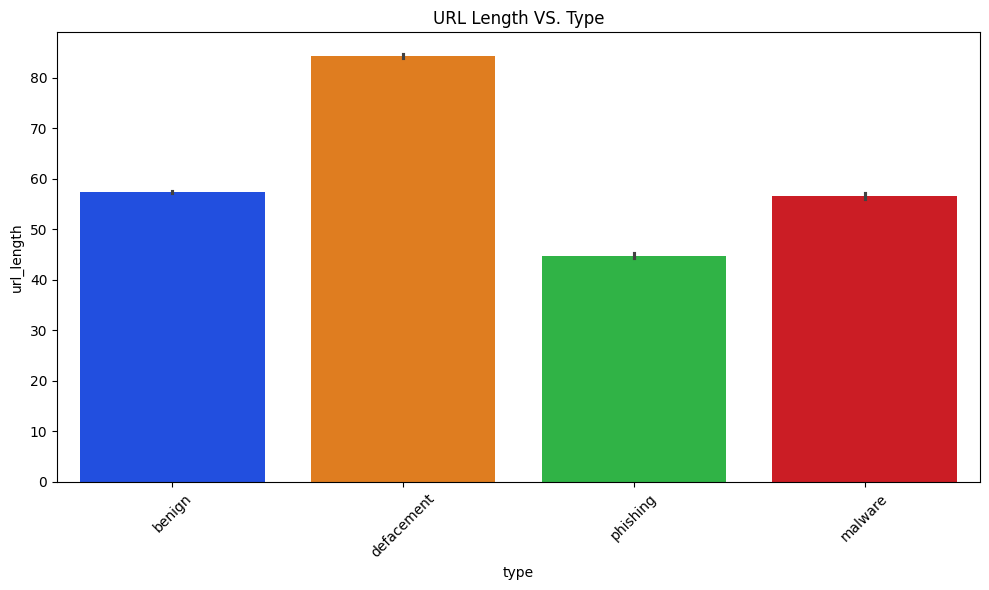

In [10]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="type", y="url_length", palette="bright", hue="type")
plt.title("URL Length VS. Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see here that past the cutoff point of a length of about 60, every URL is likely defacement.

In [11]:
# Extract domain and suffix from url
def extract_domain(url: str):
    extracted_url = tlde.extract(url)
    return f"{extracted_url.domain}.{extracted_url.suffix}"

df["domain"] = df["url"].apply(extract_domain)

df.head()

,url,type,category,url_length,domain
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net
64374,kvha.org/,benign,0,9,kvha.org


In [12]:
# Check presence in Alexa top 1000 Domains
alexa_top_1000 = []
with open("alexa-top-1000.txt", "r") as f:
    alexa_top_1000 = set([d.strip() for d in f.readlines()])

In [13]:
# 1 if in top 1000 else 0
def check_alexa(domain: str):
    return int(domain in alexa_top_1000)


df["in_alexa_top_1000"] = df["domain"].apply(check_alexa)

df["in_alexa_top_1000"].value_counts()

in_alexa_top_1000
0    213436
1     36564
Name: count, dtype: int64

In [14]:
# Check HTTPS status
# 1 if https exists else 0
def has_https(url):
    return int("https" in url)

df["has_https"] = df["url"].apply(has_https)

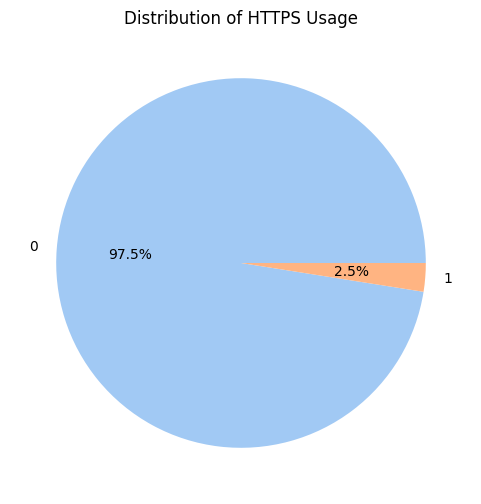

In [15]:
https_counts = df["has_https"].value_counts()

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    https_counts,
    labels=https_counts.index,
    autopct="%1.1f%%",
    colors=sns.color_palette("pastel"),
)
plt.title("Distribution of HTTPS Usage")
plt.show()


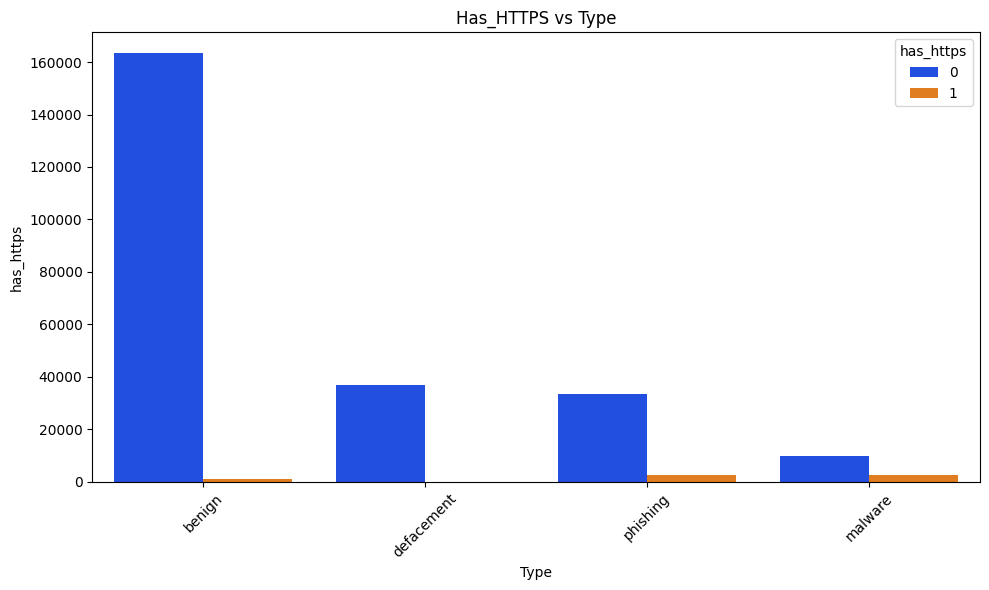

In [16]:
# Relationship between Type and HTTPS Usage
# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="type", hue="has_https", palette="bright")
plt.title("Has_HTTPS vs Type")
plt.xlabel("Type")
plt.ylabel("has_https")
plt.xticks(rotation=45)
plt.legend(title="has_https")
plt.tight_layout()
plt.show()


Most sites do not use HTTPS in our dataset and no correlation can be drawn between HTTPS usage and a benign URL.

In [17]:
# Count frequency of special characters
special_characters = ["@", "!", "?", "=", "-", "//", "#", ".", "+", "$", "*", "%", "&"]

def count_characters(url: str, character: str):
    return url.count(character)

for c in special_characters:
    df[c] = df["url"].apply(lambda url: count_characters(url, c))

df.head()

,url,type,category,url_length,domain,in_alexa_top_1000,has_https,@,!,?,=,-,//,#,.,+,$,*,%,&
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com,1,0,0,0,0,0,1,0,0,2,0,0,0,0,0
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com,0,0,0,0,0,0,10,1,0,1,0,0,0,0,0
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net,0,0,0,0,2,6,1,0,0,7,0,0,0,0,5
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net,0,0,0,0,0,0,13,1,0,2,0,0,0,0,0
64374,kvha.org/,benign,0,9,kvha.org,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [18]:
# Digit to letter ratio in URL
def calculate_digit_to_letter_ratio(url):
    digits = sum(c.isdigit() for c in url)
    letters = sum(c.isalpha() for c in url)
    if letters == 0:
        ratio = 0
    else:
        ratio = digits / letters
    return ratio

df["digit_to_letter_ratio_url"] = df["url"].apply(calculate_digit_to_letter_ratio)

df.head()

,url,type,category,url_length,domain,in_alexa_top_1000,has_https,@,!,?,...,-,//,#,.,+,$,*,%,&,digit_to_letter_ratio_url
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com,1,0,0,0,0,...,1,0,0,2,0,0,0,0,0,0.000000
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com,0,0,0,0,0,...,10,1,0,1,0,0,0,0,0,0.070588
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net,0,0,0,0,2,...,1,0,0,7,0,0,0,0,5,0.063694
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net,0,0,0,0,0,...,13,1,0,2,0,0,0,0,0,0.044776
64374,kvha.org/,benign,0,9,kvha.org,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.000000


In [19]:
# Letter to digit ratio in primary domain
df["digit_to_letter_ratio_domain"] = df["domain"].apply(calculate_digit_to_letter_ratio)

df.head()


,url,type,category,url_length,domain,in_alexa_top_1000,has_https,@,!,?,...,//,#,.,+,$,*,%,&,digit_to_letter_ratio_url,digit_to_letter_ratio_domain
188842,espn.go.com/mlb/team/_/name/tex/texas-rangers,benign,0,45,go.com,1,0,0,0,0,...,0,0,2,0,0,0,0,0,0.000000,0.000000
52618,http://onedio.com/haber/ogrencileri-duman-kons...,benign,0,107,onedio.com,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0.070588,0.000000
601223,.battle.com.wwowus.net/login/en/?3Fref=eu.batt...,benign,0,201,wwowus.net,0,0,0,0,2,...,0,0,7,0,0,0,0,5,0.063694,0.000000
337542,http://tinnhanh360.net/nghi-le-chao-doi--thach...,benign,0,89,tinnhanh360.net,0,0,0,0,0,...,1,0,2,0,0,0,0,0,0.044776,0.272727
64374,kvha.org/,benign,0,9,kvha.org,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.000000,0.000000


In [20]:
# Check if URL is an IP address
ip_pattern = (
    r"(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\."
    r"([01]?\d\d?|2[0-4]\d|25[0-5])\/)|"
    r"(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\."
    r"([01]?\d\d?|2[0-4]\d|25[0-5])\/)|"
    r"((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\/)"
    r"(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|"
    r"([0-9]+(?:\.[0-9]+){3}:[0-9]+)|"
    r"((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)"
)

def has_ip_address(url: str):
    # re.I = ignore case
    return int(re.search(ip_pattern, url, flags=re.I) is not None) 

df["has_ip"] = df["url"].apply(has_ip_address)


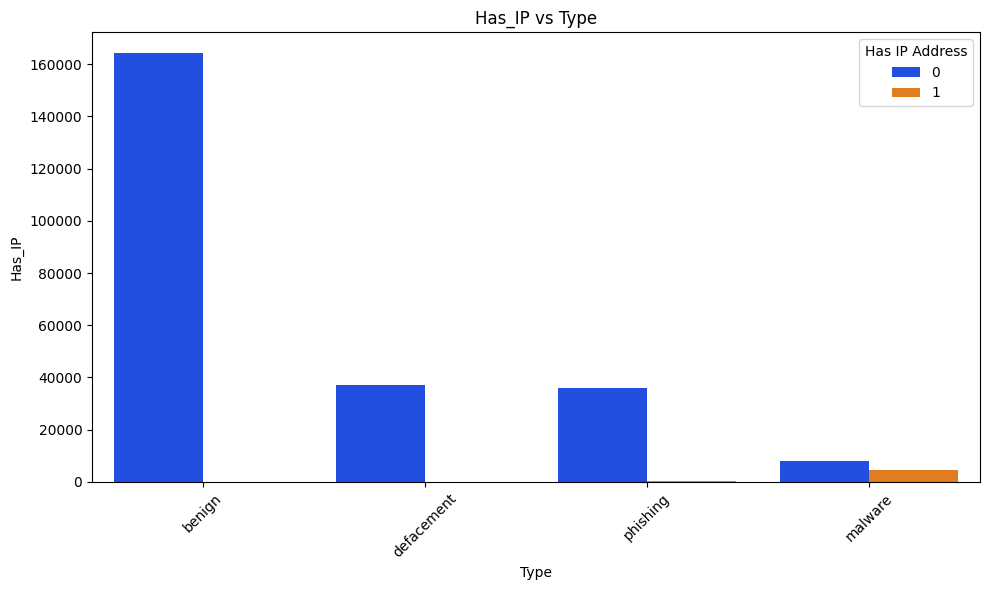

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="type", hue="has_ip", palette="bright")
plt.title("Has_IP vs Type")
plt.xlabel("Type")
plt.ylabel("Has_IP")
plt.xticks(rotation=45)
plt.legend(title="Has IP Address")
plt.tight_layout()
plt.show()


Having only an IP address has a strong correlation with being malware.

In [22]:
# Check if URL has been shortened by a service
shortening_pattern = (
    r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|"
    r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|"
    r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|"
    r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|"
    r"db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|"
    r"q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|"
    r"x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|"
    r"tr\.im|link\.zip\.net"
)


def has_shortening_service(url):
    return int(re.search(shortening_pattern, url, flags=re.I) is not None)

df["shortened"] = df["url"].apply(has_shortening_service)

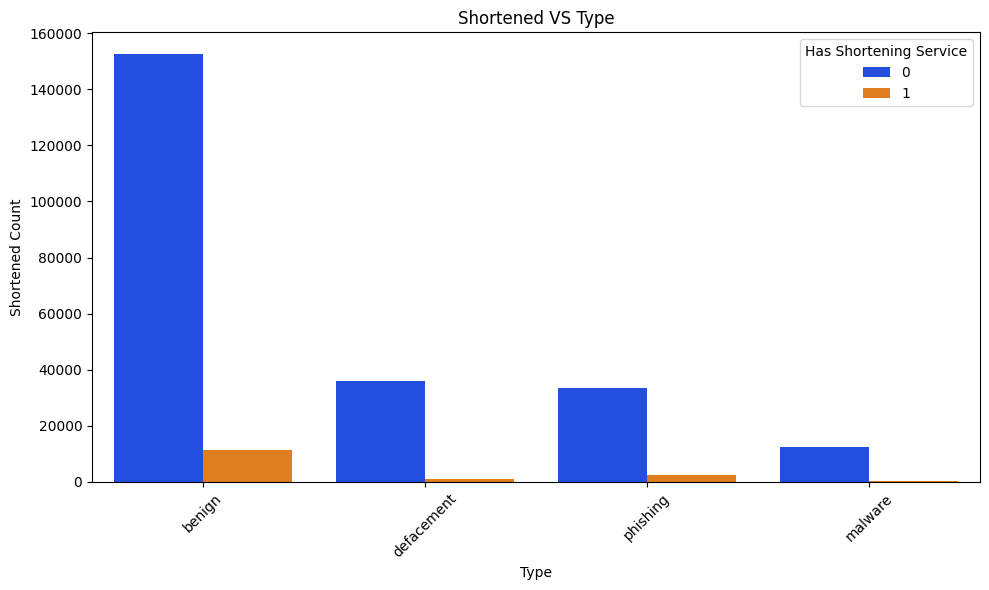

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x="type", hue="shortened", palette="bright")
plt.title("Shortened VS Type")
plt.xlabel("Type")
plt.ylabel("Shortened Count")
plt.xticks(rotation=45)
plt.legend(title="Has Shortening Service")
plt.tight_layout()
plt.show()


There is a correlation with a URL being shortened and it also being benign.

In [24]:
# Prepare training data
y = df["category"]
X = df.drop(["type", "category", "url", "domain"], axis=1)

In [25]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=53)

In [26]:
# Prepare Model and Train it
SVM_Model = SVC(gamma="auto")
SVM_Model.fit(X_train, y_train)

# Predict for train set
y_train_pred = SVM_Model.predict(X_train)

# Predict for test set
y_pred = SVM_Model.predict(X_test)

# Compute test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Test Accuracy: {test_accuracy * 100}%")
print(f"Train Accuracy: {train_accuracy * 100}%")


Test Accuracy: 86.72933333333333%
Train Accuracy: 86.97257142857143%
